End-to-End Supervised Learning Project!

# **PROJECT:** Analysis of New York City's Energy and Water Data Using Linear Learner Model on Amazon SageMaker



# Contents

1. Introduction
2. Setup
    Dataset and data ingestion
3. Data Preparation
4. Exploratory Analysis
5. Training the model
6. Plotting evaluation metrics
7. Set up hosting for the model
8. Import model into hosting
8. Create endpoint configuration
9. Create endpoint
10. Validate the model for use

# Introduction

This Notebook uses Linear Learner algorithm on Amazon Sagemaker to train, host, maintain a regression model. The data used were obtained from NYC OpenData Portal 

# Setup

This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.

# Dataset and Data Ingestion

In [2]:
# Importing Libraries

# Data processing

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Visualization

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning

from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn.feature_selection as fs
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn.metrics as metrics
from sklearn.datasets import *
import sklearn.model_selection
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import xgboost
from xgboost import XGBRegressor

# SageMaker

from time import sleep
import boto3
import sagemaker
import s3fs
import os
from time import sleep, gmtime, strftime
import json
import sys
import subprocess
import pkg_resources
import io
from urllib.parse import urlparse

# SageMaker Experiment

import time
from time import strftime

#!pip install sagemaker-experiments --> if it isn't installed.
from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker


In [3]:
import sagemaker
print(sagemaker.__version__)

2.45.0


In [4]:
data_bucket = 'just-abdul-aws' #Definfing bucket name
subfolder = 'NewYork' #Defining sub-folder name
dataset = '2018.csv'

In [5]:
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
s3 = s3fs.S3FileSystem(anon=False)
sm = boto3.Session().client('sagemaker')

In [6]:
df = pd.read_csv(f's3://{data_bucket}/{subfolder}/{dataset}')

# Understanding the data

In [7]:
df.head(5)

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,City Building,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self - reported",NYC Building Identification Number (BIN),Address 1 (self - reported),...,Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),Water Required?,Generation Date,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1009970029,1009970029,1022631,1155 Avenue of the Americas,...,Not Available,Not Available,No,04/30/2019 11:53:26 AM,40.756631,-73.982826,105.0,4.0,119,Midtown-Midtown South
1,2,8139,200,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1013150001,1013150001,1037545,200 East 42nd St.,...,7252.6,18.87,Yes,04/30/2019 11:53:27 AM,NaN,NaN,NaN,NaN,NaN,NaN
2,3,8604,114,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1009990019,1009990019,1022667,114 West 47th st,...,Not Available,Not Available,No,04/30/2019 11:53:27 AM,NaN,NaN,NaN,NaN,NaN,NaN
3,4,8841,733,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1013190047,1013190047,1037596,733 Third Avenue,...,Not Available,Not Available,No,04/30/2019 11:53:27 AM,40.753074,-73.972753,106.0,4.0,90,Turtle Bay-East Midtown
4,5,11809,Conde Nast Building,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1009950005,1009950005,1085682,4 Times Square,...,Not Available,Not Available,NaN,04/30/2019 11:53:27 AM,40.756181,-73.986244,105.0,4.0,119,Midtown-Midtown South


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25939 entries, 0 to 25938
Data columns (total 67 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       25939 non-null  object 
 1   Property Id                                                 25939 non-null  int64  
 2   Property Name                                               25939 non-null  object 
 3   Parent Property Id                                          25939 non-null  object 
 4   Parent Property Name                                        25939 non-null  object 
 5   City Building                                               25939 non-null  object 
 6   BBL - 10 digits                                             25939 non-null  object 
 7   NYC Borough, Block and Lot (BBL) self - reported            25939 non-null  object 
 

In [9]:
df.describe()

,Property Id,Postcode,Number of Buildings,Occupancy,Latitude,Longitude,Community Board,Council District
count,2.593900e+04,2.589200e+04,25939.000000,25939.000000,16834.000000,16834.000000,16834.000000,16834.000000
mean,5.045627e+06,1.842241e+05,1.240063,98.164347,40.742200,-73.928984,264.651123,22.439408
std,1.804315e+06,4.311858e+06,3.430990,9.459872,0.080676,0.069150,114.613441,14.463578
min,7.365000e+03,1.222000e+03,0.000000,0.000000,40.509037,-74.244118,101.000000,1.000000
25%,3.111576e+06,1.002800e+04,1.000000,100.000000,40.685378,-73.975683,202.000000,10.000000
50%,5.950838e+06,1.046000e+04,1.000000,100.000000,40.738306,-73.932690,302.000000,21.000000
75%,6.631356e+06,1.122000e+04,1.000000,100.000000,40.815921,-73.889371,401.000000,35.000000
max,8.729534e+06,1.143423e+08,161.000000,100.000000,40.912869,-73.700935,503.000000,51.000000


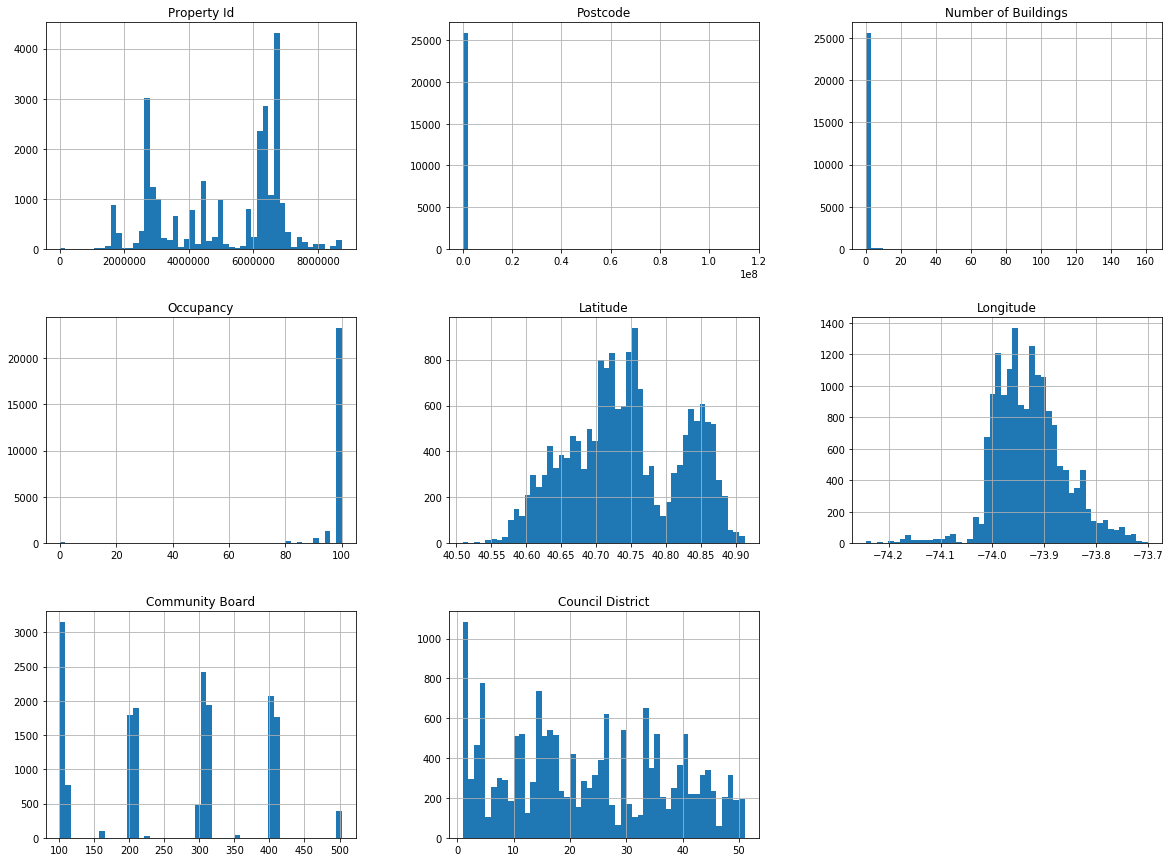

In [10]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Most of the data are in Categorical form, some features have no correlation nor add value to the target variable (Total GHG) thus need cleaning

# Data Cleaning/Preparation

In [11]:
df = df.replace('Not Available', None)

In [12]:
# Removing the character in the data.

df[['DOF Gross Floor Area  (ft²)', 'Year Built']] = df[['DOF Gross Floor Area  (ft²)', 'Year Built']].replace(',','', regex=True)

In [13]:
# Selecting Obj type which are actually numbers

cols = ['NYC Building Identification Number (BIN)','Postcode','DOF Gross Floor Area  (ft²)','Year Built','ENERGY STAR Score','Source EUI (kBtu/ft²)','Weather Normalized Site EUI (kBtu/ft²)','Site EUI (kBtu/ft²)','Weather Normalized Source EUI (kBtu/ft²)','Weather Normalized Site Electricity Intensity (kWh/ft²)','Weather Normalized Site Natural Gas Intensity (therms/ft²)','Natural Gas Use (kBtu)','Weather Normalized Site Natural Gas Use (therms)','Electricity Use - Grid Purchase (kWh)','Weather Normalized Site Electricity (kWh)','Total GHG Emissions (Metric Tons CO2e)','Direct GHG Emissions (Metric Tons CO2e)','Indirect GHG Emissions (Metric Tons CO2e)','Water Use (All Water Sources) (kgal)','Water Use Intensity (All Water Sources) (gal/ft²)']

In [14]:
# Selecting Obj type which are actually numbers

cols2 = ['BBL - 10 digits','Street Number', 'Self-Reported Gross Floor Area (ft²)','Largest Property Use Type - Gross Floor Area (ft²)','2nd Largest Property Use - Gross Floor Area (ft²)','3rd Largest Property Use Type - Gross Floor Area (ft²)','Fuel Oil #1 Use (kBtu)','Fuel Oil #2 Use (kBtu)','Fuel Oil #5 & 6 Use (kBtu)','Fuel Oil #2 Use (kBtu)','Diesel #2 Use (kBtu)','Propane Use (kBtu)','District Steam Use (kBtu)','District Chilled Water Use (kBtu)','Electricity Use - Grid Purchase (kBtu)','Annual Maximum Demand (kW)']

In [15]:
# Converting Obj type to Num

col = cols + cols2
df[col] = df[col].apply(pd.to_numeric, errors='coerce', axis=1)

In [16]:
Sum = df.isnull().sum()
Percentage = ( df.isnull().sum()/df.isnull().count())

nulls = pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage']).sort_values(by='Sum', ascending=False).head(30)
nulls

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Sum,Percentage
Largest Property Use Type - Gross Floor Area (ft²),25936,0.999884
Self-Reported Gross Floor Area (ft²),25934,0.999807
Propane Use (kBtu),15939,0.614480
Longitude,9105,0.351016
Latitude,9105,0.351016
NTA,9105,0.351016
Community Board,9105,0.351016
Council District,9105,0.351016
Census Tract,9105,0.351016
DOF Gross Floor Area (ft²),6584,0.253826


A 30% missing value threshold is selected. columns with more than 30% missing values will be dropped.

In [17]:
#Selecting the columns with more than 30% missing values

remove = nulls[nulls['Percentage']>=0.30]
remove.index.name = 'Features' # Renames the index to 'Features'
remove.reset_index(level=0, inplace=True) # Re-index's the dataframe, turning 'Features' into a column
remove

,Features,Sum,Percentage
0,Largest Property Use Type - Gross Floor Area (...,25936,0.999884
1,Self-Reported Gross Floor Area (ft²),25934,0.999807
2,Propane Use (kBtu),15939,0.614480
3,Longitude,9105,0.351016
4,Latitude,9105,0.351016
5,NTA,9105,0.351016
6,Community Board,9105,0.351016
7,Council District,9105,0.351016
8,Census Tract,9105,0.351016


In [18]:
remove['Features'].tolist()

['Largest Property Use Type - Gross Floor Area (ft²)',
 'Self-Reported Gross Floor Area (ft²)',
 'Propane Use (kBtu)',
 'Longitude',
 'Latitude',
 'NTA',
 'Community Board',
 'Council District',
 'Census Tract']

In [19]:
#Dropping the columns with more than 30% missing values

df = df.drop(remove['Features'].tolist(), axis=1)

In [20]:
# Dropping other columns that aren't useful

df = df.drop(['Order','Property Name', 'Parent Property Id','Parent Property Name', 'Property Id','BBL - 10 digits','NYC Building Identification Number (BIN)','Postcode','Street Number', 'NYC Borough, Block and Lot (BBL) self - reported','Address 1 (self - reported)','Water Required?', 'Address 2 (self - reported)','Street Name','Fuel Oil #4 Use (kBtu)','Kerosene Use (kBtu)', 'Annual Maximum Demand (MM/YYYY)', 'Generation Date','District Hot Water Use (kBtu)'], axis=1)

In [21]:
df_obj = df.select_dtypes(include=['object'])
df_num = df.select_dtypes(exclude=['object'])

In [22]:
df_num

,DOF Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),...,Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Annual Maximum Demand (kW),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²)
0,734668.0,5227.0,NaN,1982.0,1,40,79.0,110.9,110.9,45.7,...,NaN,23995341.5,7032631.5,7032631.5,NaN,2520.9,0.0,2520.9,NaN,NaN
1,380000.0,15789.0,2115.0,1956.0,1,100,62.0,193.4,190.6,101.0,...,NaN,17308898.1,5072947.2,5055495.0,NaN,2895.1,0.0,2895.1,7252.6,18.87
2,646995.0,15789.0,2115.0,1989.0,1,95,66.0,155.6,154.6,70.3,...,9632.3,25783057.2,7556580.9,7446568.4,NaN,3155.8,51.2,3104.7,7252.6,18.87
3,405399.0,15789.0,2115.0,1961.0,1,100,64.0,181.5,178.2,97.1,...,9632.3,15906223.2,4661846.8,4612102.7,NaN,2826.2,0.0,2826.2,7252.6,18.87
4,NaN,62864.0,2115.0,1999.0,1,100,42.0,226.1,227.3,100.4,...,389906.7,109258703.4,32021890.4,32021890.4,NaN,12179.3,1991.7,10187.6,7252.6,18.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25934,375225.0,9980.0,8510.0,1972.0,1,75,100.0,20.4,20.4,19.4,...,36466.0,821766.1,240845.8,240845.8,0.0,193.7,193.7,0.0,294.2,8.93
25935,375225.0,9980.0,8510.0,1973.0,2,75,27.0,134.7,133.0,86.0,...,228877.1,9519753.3,2790079.8,2709471.4,687.8,2014.0,1207.8,806.2,18450.8,49.17
25936,27424.0,9980.0,8510.0,2015.0,1,90,6.0,219.7,218.5,107.1,...,12557.0,1680788.6,492610.9,489166.9,687.8,209.0,66.7,142.3,2675.8,97.57
25937,43073.0,9980.0,8510.0,1900.0,1,100,6.0,219.7,218.5,107.1,...,12557.0,686541.0,201213.6,201213.6,687.8,209.0,66.7,58.1,10.5,0.24


# Dealing with NaN values.

Nan values will be replaced with the median of that feature/column

In [23]:
# Creating a pipeline that handles NaNs as well as transforms data using standard scaler.

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median"))])

In [24]:
df_pipeline = num_pipeline.fit_transform(df_num)

In [25]:
df_pipe = pd.DataFrame(df_pipeline, columns=df_num.columns,index=df_num.index)

In [26]:
df_pipe

,DOF Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),...,Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Annual Maximum Demand (kW),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²)
0,734668.0,5227.0,5712.0,1982.0,1.0,40.0,79.0,110.9,110.9,45.7,...,30269.4,23995341.5,7032631.5,7032631.5,152.0,2520.9,0.0,2520.9,3242.1,49.17
1,380000.0,15789.0,2115.0,1956.0,1.0,100.0,62.0,193.4,190.6,101.0,...,30269.4,17308898.1,5072947.2,5055495.0,152.0,2895.1,0.0,2895.1,7252.6,18.87
2,646995.0,15789.0,2115.0,1989.0,1.0,95.0,66.0,155.6,154.6,70.3,...,9632.3,25783057.2,7556580.9,7446568.4,152.0,3155.8,51.2,3104.7,7252.6,18.87
3,405399.0,15789.0,2115.0,1961.0,1.0,100.0,64.0,181.5,178.2,97.1,...,9632.3,15906223.2,4661846.8,4612102.7,152.0,2826.2,0.0,2826.2,7252.6,18.87
4,56986.0,62864.0,2115.0,1999.0,1.0,100.0,42.0,226.1,227.3,100.4,...,389906.7,109258703.4,32021890.4,32021890.4,152.0,12179.3,1991.7,10187.6,7252.6,18.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25934,375225.0,9980.0,8510.0,1972.0,1.0,75.0,100.0,20.4,20.4,19.4,...,36466.0,821766.1,240845.8,240845.8,0.0,193.7,193.7,0.0,294.2,8.93
25935,375225.0,9980.0,8510.0,1973.0,2.0,75.0,27.0,134.7,133.0,86.0,...,228877.1,9519753.3,2790079.8,2709471.4,687.8,2014.0,1207.8,806.2,18450.8,49.17
25936,27424.0,9980.0,8510.0,2015.0,1.0,90.0,6.0,219.7,218.5,107.1,...,12557.0,1680788.6,492610.9,489166.9,687.8,209.0,66.7,142.3,2675.8,97.57
25937,43073.0,9980.0,8510.0,1900.0,1.0,100.0,6.0,219.7,218.5,107.1,...,12557.0,686541.0,201213.6,201213.6,687.8,209.0,66.7,58.1,10.5,0.24


# Dealing with Cat datatype

In [27]:
le=LabelEncoder()

for col in df_obj.columns.values:
    # Encoding only categorical variables
    if df_obj[col].dtypes=='object':
        # Using whole data to form an exhaustive list of levels
        data=df_obj[col]
        le.fit(data.values)
        df_obj[col]=le.transform(df_obj[col])

In [28]:
df_obj

,City Building,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,3rd Largest Property Use Type,Metered Areas (Energy),Metered Areas (Water)
0,0,2,33,86,32,2,24,8,2
1,0,2,33,97,32,50,2,8,5
2,0,2,13,325,13,50,2,8,5
3,0,2,33,889,32,50,2,8,5
4,0,2,33,973,32,50,2,8,5
...,...,...,...,...,...,...,...,...,...
25934,0,0,30,679,29,29,25,8,5
25935,0,0,30,679,29,29,25,8,5
25936,0,1,19,478,19,29,25,8,5
25937,0,2,30,679,29,29,25,8,5


In [29]:
df_cleaned = pd.concat([df_pipe,df_obj], axis =1)

In [30]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25939 entries, 0 to 25938
Data columns (total 39 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   DOF Gross Floor Area  (ft²)                                 25939 non-null  float64
 1   2nd Largest Property Use - Gross Floor Area (ft²)           25939 non-null  float64
 2   3rd Largest Property Use Type - Gross Floor Area (ft²)      25939 non-null  float64
 3   Year Built                                                  25939 non-null  float64
 4   Number of Buildings                                         25939 non-null  float64
 5   Occupancy                                                   25939 non-null  float64
 6   ENERGY STAR Score                                           25939 non-null  float64
 7   Source EUI (kBtu/ft²)                                       25939 non-null  float64
 

# Feature Selection

In [31]:
# Selecting features and the target variable

Y_selection = df_cleaned['Total GHG Emissions (Metric Tons CO2e)']  #Target Feature
X_selection = df_cleaned.drop("Total GHG Emissions (Metric Tons CO2e)", 1)

In [32]:
# Partitioning the dataset into 2/3 training and 1/3 test set.
X_train_selection, X_test_selection, Y_train_selection, Y_test_selection = sklearn.model_selection.train_test_split(X_selection, Y_selection, test_size=0.33)

# Further splitting the training set into a validation set; 2/3 training set, and 1/3 validation set
X_train_selection, X_val_selection, Y_train_selection, Y_val_selection = sklearn.model_selection.train_test_split(X_train_selection, Y_train_selection, test_size=0.33)

In [33]:
# Feature Selection using XGBRegressor

X_data, y_label = make_regression(
    n_samples=X_train_selection.shape[0], n_features=X_train_selection.shape[1], n_informative=10, random_state=1
)
xgboost_model = XGBRegressor()
xgboost_model.fit(X_data, y_label)

feature_scores = []
feature_importances_xgboost = xgboost_model.feature_importances_
for index, importance_score in enumerate(feature_importances_xgboost):
    feature_scores.append([X_train_selection.columns[index], importance_score])

In [34]:
# List of features and their respective scores, depicting their importance

sorted_scores = sorted(np.array(feature_scores), key=lambda s: float(s[1]), reverse=True) 
print(np.array(sorted_scores))

[['Weather Normalized Site Electricity (kWh)' '0.17540875']
 ['Site EUI (kBtu/ft²)' '0.1368753']
 ['3rd Largest Property Use Type' '0.1244295']
 ['Indirect GHG Emissions (Metric Tons CO2e)' '0.12201577']
 ['Largest Property Use Type' '0.12166264']
 ['Fuel Oil #5 & 6 Use (kBtu)' '0.09345414']
 ['DOF Gross Floor Area  (ft²)' '0.06590423']
 ['3rd Largest Property Use Type - Gross Floor Area (ft²)' '0.059950735']
 ['List of All Property Use Types at Property' '0.057724368']
 ['Diesel #2 Use (kBtu)' '0.0021826986']
 ['Direct GHG Emissions (Metric Tons CO2e)' '0.0020963778']
 ['Electricity Use - Grid Purchase (kBtu)' '0.0019719838']
 ['2nd Largest Property Use Type' '0.0018877045']
 ['Primary Property Type - Self Selected' '0.0017099641']
 ['Natural Gas Use (kBtu)' '0.0016801067']
 ['Metered Areas (Energy)' '0.001636952']
 ['Weather Normalized Site Natural Gas Use (therms)' '0.0015644416']
 ['Weather Normalized Site Natural Gas Intensity (therms/ft²)'
  '0.0015633831']
 ['Fuel Oil #2 Use (kB

In [35]:
features = pd.DataFrame(feature_scores, columns=['Features','Score'])
features.sort_values(by='Score', ascending=False).head(15)

,Features,Score
23,Weather Normalized Site Electricity (kWh),0.175409
9,Site EUI (kBtu/ft²),0.136875
35,3rd Largest Property Use Type,0.124430
26,Indirect GHG Emissions (Metric Tons CO2e),0.122016
33,Largest Property Use Type,0.121663
15,Fuel Oil #5 & 6 Use (kBtu),0.093454
0,DOF Gross Floor Area (ft²),0.065904
2,3rd Largest Property Use Type - Gross Floor Ar...,0.059951
32,List of All Property Use Types at Property,0.057724
16,Diesel #2 Use (kBtu),0.002183


In [36]:
# Setting a score threshold of 0.002

Top_features = features[features['Score']>=0.002]
Top_features

,Features,Score
0,DOF Gross Floor Area (ft²),0.065904
2,3rd Largest Property Use Type - Gross Floor Ar...,0.059951
9,Site EUI (kBtu/ft²),0.136875
15,Fuel Oil #5 & 6 Use (kBtu),0.093454
16,Diesel #2 Use (kBtu),0.002183
23,Weather Normalized Site Electricity (kWh),0.175409
25,Direct GHG Emissions (Metric Tons CO2e),0.002096
26,Indirect GHG Emissions (Metric Tons CO2e),0.122016
32,List of All Property Use Types at Property,0.057724
33,Largest Property Use Type,0.121663


In [37]:
# List of Top features

Top_features['Features'].tolist()

['DOF Gross Floor Area  (ft²)',
 '3rd Largest Property Use Type - Gross Floor Area (ft²)',
 'Site EUI (kBtu/ft²)',
 'Fuel Oil #5 & 6 Use (kBtu)',
 'Diesel #2 Use (kBtu)',
 'Weather Normalized Site Electricity (kWh)',
 'Direct GHG Emissions (Metric Tons CO2e)',
 'Indirect GHG Emissions (Metric Tons CO2e)',
 'List of All Property Use Types at Property',
 'Largest Property Use Type',
 '3rd Largest Property Use Type']

# Checking for Multi-Collinearity

In [38]:
# VIF = 1, indicates no correlation between the independent variable and the other variables 
# VIF exceeding 5 or 10 indicates high multicollinearity between the independent variable and the others

def calc_vif(C):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = C.columns
    vif["VIF"] = [variance_inflation_factor(C.values, i) for i in range(C.shape[1])]

    return(vif)

In [39]:
X_selection[Top_features['Features'].tolist()]

,DOF Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Site EUI (kBtu/ft²),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Weather Normalized Site Electricity (kWh),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),List of All Property Use Types at Property,Largest Property Use Type,3rd Largest Property Use Type
0,734668.0,5712.0,45.7,2882919.0,69000.0,7032631.5,0.0,2520.9,86,32,24
1,380000.0,2115.0,101.0,2882919.0,69000.0,5055495.0,0.0,2895.1,97,32,2
2,646995.0,2115.0,70.3,2882919.0,69000.0,7446568.4,51.2,3104.7,325,13,2
3,405399.0,2115.0,97.1,2882919.0,69000.0,4612102.7,0.0,2826.2,889,32,2
4,56986.0,2115.0,100.4,2882919.0,69000.0,32021890.4,1991.7,10187.6,973,32,2
...,...,...,...,...,...,...,...,...,...,...,...
25934,375225.0,8510.0,19.4,478984.5,14322605.8,240845.8,193.7,0.0,679,29,25
25935,375225.0,8510.0,86.0,478984.5,14322605.8,2709471.4,1207.8,806.2,679,29,25
25936,27424.0,8510.0,107.1,478984.5,14322605.8,489166.9,66.7,142.3,478,19,25
25937,43073.0,8510.0,107.1,478984.5,14322605.8,201213.6,66.7,58.1,679,29,25


In [40]:
C = X_selection[Top_features['Features'].tolist()].iloc[:,:]
calc_vif(C)

,variables,VIF
0,DOF Gross Floor Area (ft²),1.432119
1,3rd Largest Property Use Type - Gross Floor Ar...,1.219515
2,Site EUI (kBtu/ft²),5.524459
3,Fuel Oil #5 & 6 Use (kBtu),1.477446
4,Diesel #2 Use (kBtu),1.239906
5,Weather Normalized Site Electricity (kWh),1.483562
6,Direct GHG Emissions (Metric Tons CO2e),1.193485
7,Indirect GHG Emissions (Metric Tons CO2e),5.494043
8,List of All Property Use Types at Property,33.208199
9,Largest Property Use Type,29.140909


High Correlations found between:
    1) List of All Property Use Types at Property
    2) Largest Property Use Type
    3) 3rd Largest Property Use Type

In [41]:
# Uncorrellated top features

Top_feature = X_selection[['DOF Gross Floor Area  (ft²)',
 '3rd Largest Property Use Type - Gross Floor Area (ft²)',
 'Site EUI (kBtu/ft²)',
 'Fuel Oil #5 & 6 Use (kBtu)',
 'Diesel #2 Use (kBtu)',
 'Weather Normalized Site Electricity (kWh)',
 'Direct GHG Emissions (Metric Tons CO2e)',
 'Indirect GHG Emissions (Metric Tons CO2e)',
 'Largest Property Use Type']]

In [42]:
C = Top_feature.iloc[:,:]
calc_vif(C)

,variables,VIF
0,DOF Gross Floor Area (ft²),1.429931
1,3rd Largest Property Use Type - Gross Floor Ar...,1.215762
2,Site EUI (kBtu/ft²),5.522052
3,Fuel Oil #5 & 6 Use (kBtu),1.458902
4,Diesel #2 Use (kBtu),1.233801
5,Weather Normalized Site Electricity (kWh),1.467141
6,Direct GHG Emissions (Metric Tons CO2e),1.191741
7,Indirect GHG Emissions (Metric Tons CO2e),5.491215
8,Largest Property Use Type,1.911331


In [43]:
# No Correlation observed

selected_df = X_selection[['DOF Gross Floor Area  (ft²)',
 '3rd Largest Property Use Type - Gross Floor Area (ft²)',
 'Site EUI (kBtu/ft²)',
 'Fuel Oil #5 & 6 Use (kBtu)',
 'Diesel #2 Use (kBtu)',
 'Weather Normalized Site Electricity (kWh)',
 'Direct GHG Emissions (Metric Tons CO2e)',
 'Indirect GHG Emissions (Metric Tons CO2e)',
 'Largest Property Use Type']]

In [44]:
selected_df

,DOF Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Site EUI (kBtu/ft²),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Weather Normalized Site Electricity (kWh),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Largest Property Use Type
0,734668.0,5712.0,45.7,2882919.0,69000.0,7032631.5,0.0,2520.9,32
1,380000.0,2115.0,101.0,2882919.0,69000.0,5055495.0,0.0,2895.1,32
2,646995.0,2115.0,70.3,2882919.0,69000.0,7446568.4,51.2,3104.7,13
3,405399.0,2115.0,97.1,2882919.0,69000.0,4612102.7,0.0,2826.2,32
4,56986.0,2115.0,100.4,2882919.0,69000.0,32021890.4,1991.7,10187.6,32
...,...,...,...,...,...,...,...,...,...
25934,375225.0,8510.0,19.4,478984.5,14322605.8,240845.8,193.7,0.0,29
25935,375225.0,8510.0,86.0,478984.5,14322605.8,2709471.4,1207.8,806.2,29
25936,27424.0,8510.0,107.1,478984.5,14322605.8,489166.9,66.7,142.3,19
25937,43073.0,8510.0,107.1,478984.5,14322605.8,201213.6,66.7,58.1,29


# Preparing data for Amazon SageMaker

In [45]:
X = selected_df
Y = df_cleaned['Total GHG Emissions (Metric Tons CO2e)']  #Target Feature

In [46]:
# Partitioning the dataset into 2/3 training and 1/3 test set.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.33)

# Further splitting the training set into a validation set; 2/3 training set, and 1/3 validation set
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

For the Amazon SageMaker built-in XGBoost algorithm, the target feature column must be the first column in the dataframe.

In [47]:
train = pd.concat([Y_train, X_train], axis= 1)
val = pd.concat([Y_val, X_val], axis=1)
test = X_test

The 2017 and 2019 data have been cleaned using the preprocessing script, so they'd be imported from Amazon S3

In [48]:
dataset_2017 = 'cleaned_2017.csv'
dataset_2019 = 'cleaned_2019.csv'

In [49]:
data_2017 = pd.read_csv(f's3://{data_bucket}/{subfolder}/{dataset_2017}')
data_2019 = pd.read_csv(f's3://{data_bucket}/{subfolder}/{dataset_2019}')

In [50]:
data_2017 = data_2017.drop("Unnamed: 0", 1)
data_2019 = data_2019.drop("Unnamed: 0", 1)

In [51]:
#Preparing the 2017 and 2019 dataset for the model 

Y_2017 = data_2017['Total GHG Emissions (Metric Tons CO2e)'] # Target
X_2017 = data_2017.drop("Total GHG Emissions (Metric Tons CO2e)", 1)

Y_2019 = data_2019['Total GHG Emissions (Metric Tons CO2e)']  # Target
X_2019 = data_2019.drop("Total GHG Emissions (Metric Tons CO2e)", 1)

In [52]:
# Reducing the test size to 50%

X_train_2017, X_test_2017, Y_train_2017, Y_test_2017 = sklearn.model_selection.train_test_split(X_2017, Y_2017, test_size=0.50)
X_train_2019, X_test_2019, Y_train_2019, Y_test_2019 = sklearn.model_selection.train_test_split(X_2019, Y_2019, test_size=0.50)

# Converting Data to csv

In [53]:
train_file = train.to_csv(None, header=False, index=False).encode() # Doesn't include column header
train_file_header = train.to_csv(None, index=False).encode()
val_file = val.to_csv(None, header=False, index=False).encode() #Encode is to ensure text in csv is saved in the right format
test_file = test.to_csv(None, header=False, index=False).encode()
test_2017 = X_test_2017.to_csv(None, header=False, index=False).encode()
test_2019 = X_test_2019.to_csv(None, header=False, index=False).encode()

# Saving the CSV files to S3

In [54]:
with s3.open(f'{data_bucket}/{subfolder}/processed/train.csv', 'wb') as f:
    f.write(train_file)
with s3.open(f'{data_bucket}/{subfolder}/train_headers/train_data_with_headers.csv', 'wb') as f:
    f.write(train_file_header)
with s3.open(f'{data_bucket}/{subfolder}/processed/val.csv', 'wb') as f:
    f.write(val_file)
with s3.open(f'{data_bucket}/{subfolder}/processed/test.csv', 'wb') as f:
    f.write(test_file)
with s3.open(f'{data_bucket}/{subfolder}/processed/test_2017.csv', 'wb') as f:
    f.write(test_2017)
with s3.open(f'{data_bucket}/{subfolder}/processed/test_2019.csv', 'wb') as f:
    f.write(test_2019)

# File Location

In [55]:
raw_data_location = f's3://{data_bucket}/{subfolder}/{dataset}'
train_location = f's3://{data_bucket}/{subfolder}/processed/train.csv'
val_location = f's3://{data_bucket}/{subfolder}/processed/val.csv'
test_location = f's3://{data_bucket}/{subfolder}/processed/test.csv'
test_2017_location = f's3://{data_bucket}/{subfolder}/processed/test_2017.csv'
test_2019_location = f's3://{data_bucket}/{subfolder}/processed/test_2019.csv'

# Preparing the CSV data for SageMaker

In [56]:
input_train = sagemaker.TrainingInput(s3_data=train_location, content_type="text/csv")
input_validation = sagemaker.TrainingInput(s3_data=val_location, content_type="text/csv")

# Creating SageMaker Experiment

Sagemaker experiment helps track preprocessing and training changes

In [57]:
# Create a SageMaker Experiment

create_date = strftime("%Y-%m-%d-%H-%M-%S")
NYC_experiment = Experiment.create(experiment_name = "NYC-Build-train-deploy-{}".format(create_date),
                                    description = "Predict GHG Emission from Energy and Water data",
                                   sagemaker_boto_client=sm,
                                    tags = [{'Key': 'NYC-experiments', 'Value': 'NYC'}])
print(NYC_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f80a19c18d0>,experiment_name='NYC-Build-train-deploy-2021-06-17-20-41-09',description='Predict GHG Emission from Energy and Water data',tags=[{'Key': 'NYC-experiments', 'Value': 'NYC'}],experiment_arn='arn:aws:sagemaker:us-east-2:077107849065:experiment/nyc-build-train-deploy-2021-06-17-20-41-09',response_metadata={'RequestId': '3bd7745e-9fa9-41bf-94e0-f9376d4ed9a3', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '3bd7745e-9fa9-41bf-94e0-f9376d4ed9a3', 'content-type': 'application/x-amz-json-1.1', 'content-length': '114', 'date': 'Thu, 17 Jun 2021 20:41:09 GMT'}, 'RetryAttempts': 0})


In [58]:
# Start Tracking parameters used in the Pre-processing pipeline.

with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({"train_test_split_ratio": 0.3, "random_state":0})
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="ccdefault-raw-dataset", media_type="s3/uri", value=raw_data_location)
    tracker.log_input(name="ccdefault-train-dataset", media_type="s3/uri", value=train_location)
    tracker.log_input(name="ccdefault-val-dataset", media_type="s3/uri", value=val_location)
    tracker.log_input(name="ccdefault-test-dataset", media_type="s3/uri", value=test_location)
    tracker.log_input(name="ccdefault-test2017-dataset", media_type="s3/uri", value=test_2017_location)
    tracker.log_input(name="ccdefault-test2019-dataset", media_type="s3/uri", value=test_2019_location)

# Select and Training the Model

In [59]:
# Select the linear-learner model (regression)

models = ["linear-learner"]

In [60]:
sess = sagemaker.Session()

In [61]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner', 'latest')

# Tracking/Monitoring

preprocessing_trial_component = tracker.trial_component

trial_name = "NYC-training-job-{}".format(create_date)
NYC_trial = Trial.create(trial_name=trial_name, experiment_name=NYC_experiment.experiment_name)

NYC_trial.add_trial_component(preprocessing_trial_component)
NYC_training_job_name = "demo-training-job-{}".format(create_date)


model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path= f's3://{data_bucket}/{subfolder}/output',
    sagemaker_session=sess)

# Setting-up Hyperparameter

model.set_hyperparameters(
    feature_dim=X_train.shape[1], 
    predictor_type="regressor", 
    mini_batch_size=100
    )
    
model.fit({"train": input_train, "validation": input_validation}, wait=True, 
          job_name=NYC_training_job_name,  
         experiment_config={"TrialName": NYC_trial.trial_name, #log training job in Trials for lineage
            "TrialComponentDisplayName": "Training",
        },) 

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: demo-training-job-2021-06-17-20-41-09


2021-06-17 20:41:10 Starting - Starting the training job...
2021-06-17 20:41:33 Starting - Launching requested ML instancesProfilerReport-1623962470: InProgress
......
2021-06-17 20:42:33 Starting - Preparing the instances for training......
2021-06-17 20:43:33 Downloading - Downloading input data
2021-06-17 20:43:33 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/17/2021 20:43:56 INFO 140119864366912] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto

In [62]:
%%time

LL_transformer = model.transformer(instance_count = 1, instance_type = 'ml.m5.large')

INFO:sagemaker:Creating model with name: linear-learner-2021-06-17-20-44-52-688


CPU times: user 19.6 ms, sys: 2.89 ms, total: 22.5 ms
Wall time: 796 ms


In [63]:
%%time

LL_transformer.transform(test_location, split_type='Line', content_type='text/csv')

INFO:sagemaker:Creating transform job with name: linear-learner-2021-06-17-20-44-53-492


...........................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[06/17/2021 20:49:15 INFO 140197338535744] loaded entry point class algorithm.serve.server_config:config_api
[06/17/2021 20:49:15 INFO 140197338535744] loading entry points
[06/17/2021 20:49:15 INFO 140197338535744] loaded request iterator application/json
[06/17/2021 20:49:15 INFO 140197338535744] loaded request iterator application/jsonlines
[06/17/2021 20:49:15 INFO 140197338535744] loaded request iterator application/x-recordio-protobuf
[06/17/2021 20:49:15 INFO 140197338535744] loaded request iterator text/csv
[06/17/2021 20:49:15 INFO 140197338535744] loaded response encoder application/json
[06/17/2021 20:49:15 INFO 140197338535744] loaded response encoder application/jsonlines
[06/17/2021 20:49:15 INFO 140197338535744] loaded response encoder application/x-recordio-protobuf
[06/17/2021 20:49:15 INFO 140197338535744] loaded response encoder text/csv
[06/1

In [64]:
LL_transformer.wait()

Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[06/17/2021 20:49:15 INFO 140197338535744] loaded entry point class algorithm.serve.server_config:config_api
[06/17/2021 20:49:15 INFO 140197338535744] loading entry points
[06/17/2021 20:49:15 INFO 140197338535744] loaded request iterator application/json
[06/17/2021 20:49:15 INFO 140197338535744] loaded request iterator application/jsonlines
[06/17/2021 20:49:15 INFO 140197338535744] loaded request iterator application/x-recordio-protobuf
[06/17/2021 20:49:15 INFO 140197338535744] loaded request iterator text/csv
[06/17/2021 20:49:15 INFO 140197338535744] loaded response encoder application/json
[06/17/2021 20:49:15 INFO 140197338535744] loaded response encoder application/jsonlines
[06/17/2021 20:49:15 INFO 140197338535744] loaded response encoder application/x-recordio-protobuf
[06/17/2021

In [65]:
# Specify's the batch output location

data_dir =  f's3://{data_bucket}/{subfolder}/processed/'

!aws s3 cp --recursive $LL_transformer.output_path $data_dir

copy: s3://sagemaker-us-east-2-077107849065/linear-learner-2021-06-17-20-44-53-492/test.csv.out to s3://just-abdul-aws/NewYork/processed/test.csv.out


# Reviewing Batch Transform Output

In [66]:
# Function to access the batch transform result

def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')
pred = get_csv_output_from_s3(LL_transformer.output_path, 'test.csv.out')
pred = pd.read_csv(io.StringIO(pred), sep=",", header=None)
pred

,0
0,"{""score"":1180.2452392578125}"
1,"{""score"":535.0238037109375}"
2,"{""score"":320.9342041015625}"
3,"{""score"":525.9508056640625}"
4,"{""score"":1028.5606689453125}"
...,...
8555,"{""score"":493.474853515625}"
8556,"{""score"":282.6531982421875}"
8557,"{""score"":752.7894287109375}"
8558,"{""score"":30.02734375}"


In [67]:
pred.columns = ['Prediction'] # Renaming the column
pred['Prediction'] = pred.Prediction.str.replace(r"[a-zA-Z]",'') # Removing the str.
pred['Prediction'] = pred.Prediction.str.replace(r'[{}\""\:]','') # Removing Special Character
pred['Prediction'] = pred['Prediction'].apply(pd.to_numeric)
pred

,Prediction
0,1180.245239
1,535.023804
2,320.934204
3,525.950806
4,1028.560669
...,...
8555,493.474854
8556,282.653198
8557,752.789429
8558,30.027344


In [68]:
test_mae_linear = np.mean(np.abs(Y_test - pred['Prediction'].tolist()))
test_mae_baseline = np.mean(np.abs(Y_test - np.median(Y_train)))  ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 563.385
Test MAE Linear: 213.598


In [69]:
actual = Y_test
actual = actual.reset_index(drop=True)

In [70]:
model_result = pd.concat([pred,actual], axis=1)
model_result

,Prediction,Total GHG Emissions (Metric Tons CO2e)
0,1180.245239,1171.7
1,535.023804,276.8
2,320.934204,250.7
3,525.950806,378.2
4,1028.560669,960.6
...,...,...
8555,493.474854,341.5
8556,282.653198,200.5
8557,752.789429,706.8
8558,30.027344,57.7


# Deploying Model as an endpoint and config data capture

In [ ]:
import boto3
import sagemaker

import sys
import IPython

if int(sagemaker.__version__.split('.')[0]) == 2:
    print("Installing previous SageMaker Version and restarting the kernel")
    !{sys.executable} -m pip install sagemaker==1.72.0
    IPython.Application.instance().kernel.do_shutdown(True)

else:
    print("Version is good")

In [72]:
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.predictor import csv_serializer

sm_client = boto3.client('sagemaker')

latest_training_job = sm_client.list_training_jobs(MaxResults=1,
                                                SortBy='CreationTime',
                                                SortOrder='Descending')

training_job_name=TrainingJobName=latest_training_job['TrainingJobSummaries'][0]['TrainingJobName']

training_job_description = sm_client.describe_training_job(TrainingJobName=training_job_name)

model_data = training_job_description['ModelArtifacts']['S3ModelArtifacts']
container_uri = training_job_description['AlgorithmSpecification']['TrainingImage']

# create a model.
def create_model(role, model_name, container_uri, model_data):
    return sm_client.create_model(
        ModelName=model_name,
        PrimaryContainer={
        'Image': container_uri,
        'ModelDataUrl': model_data,
        },
        ExecutionRoleArn=role)
    

try:
    model = create_model(role, training_job_name, container_uri, model_data)
except Exception as e:
        sm_client.delete_model(ModelName=training_job_name)
        model = create_model(role, training_job_name, container_uri, model_data)
        

print('Model created: '+model['ModelArn'])

Model created: arn:aws:sagemaker:us-east-2:077107849065:model/demo-training-job-2021-06-17-20-41-09


# Data configuration settings

Tells SageMaker to capture 100% of the inference payloads received by the endpoint, capture both inputs and outputs

In [73]:
s3_capture_upload_path = 's3://{}/{}/monitoring/datacapture'.format(data_bucket, subfolder)
data_capture_configuration = {
    "EnableCapture": True,
    "InitialSamplingPercentage": 100,
    "DestinationS3Uri": s3_capture_upload_path,
    "CaptureOptions": [
        { "CaptureMode": "Output" },
        { "CaptureMode": "Input" }
    ],
    "CaptureContentTypeHeader": {
       "CsvContentTypes": ["text/csv"],
       "JsonContentTypes": ["application/json"]}}

# End Point Configuration

In [74]:
def create_endpoint_config(model_config, data_capture_config): 
    return sm_client.create_endpoint_config(
                                                EndpointConfigName=model_config,
                                                ProductionVariants=[
                                                        {
                                                            'VariantName': 'AllTraffic',
                                                            'ModelName': model_config,
                                                            'InitialInstanceCount': 1,
                                                            'InstanceType': 'ml.m4.xlarge',
                                                            'InitialVariantWeight': 1.0,
                                                },
                                                    
                                                    ],
                                                DataCaptureConfig=data_capture_config
                                                )




try:
    endpoint_config = create_endpoint_config(training_job_name, data_capture_configuration)
except Exception as e:
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint)
    endpoint_config = create_endpoint_config(training_job_name, data_capture_configuration)

print('Endpoint configuration created: '+ endpoint_config['EndpointConfigArn'])

Endpoint configuration created: arn:aws:sagemaker:us-east-2:077107849065:endpoint-config/demo-training-job-2021-06-17-20-41-09


# Hosting and Testing the Model (creating endpoint)

In [75]:
endpoint_name = training_job_name
def create_endpoint(endpoint_name, config_name):
    return sm_client.create_endpoint(
                                    EndpointName=endpoint_name,
                                    EndpointConfigName=training_job_name
                                )


try:
    endpoint = create_endpoint(endpoint_name, endpoint_config)
except Exception as e:
    sm_client.delete_endpoint(EndpointName=endpoint_name)
    endpoint = create_endpoint(endpoint_name, endpoint_config)

print('Endpoint created: '+ endpoint['EndpointArn'])

Endpoint created: arn:aws:sagemaker:us-east-2:077107849065:endpoint/demo-training-job-2021-06-17-20-41-09


In [81]:
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

In [82]:
%%time
from itertools import islice
import math
import struct
import boto3
from sagemaker.predictor import csv_serializer


runtime_client = boto3.client('sagemaker-runtime')


with s3.open(f'{data_bucket}/{subfolder}/processed/test.csv') as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name, ContentType="text/csv", Body=payload
)
result = json.loads(response["Body"].read().decode())
Y_pred = np.array([r["score"] for r in result["predictions"]])

CPU times: user 33.8 ms, sys: 14.8 ms, total: 48.6 ms
Wall time: 463 ms


# Verify that Model Monitor is correctly capturing the incoming data.

In [85]:
Y_pred

array([1180.24523926,  535.02380371,  320.9342041 , ...,  752.78942871,
         30.02731323,  945.70556641])

In [87]:
# Extract the captured json files.
data_capture_prefix = '{}/monitoring'.format(subfolder)
s3_client = boto3.Session().client('s3')
current_endpoint_capture_prefix = '{}/datacapture/{}/AllTraffic'.format(data_capture_prefix, endpoint_name)
print(current_endpoint_capture_prefix)
result = s3_client.list_objects(Bucket=data_bucket, Prefix=current_endpoint_capture_prefix)
capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]
print("Found Capture Files:")
print("\n ".join(capture_files))


capture_files[0]

NewYork/monitoring/datacapture/demo-training-job-2021-06-17-20-41-09/AllTraffic
Found Capture Files:
NewYork/monitoring/datacapture/demo-training-job-2021-06-17-20-41-09/AllTraffic/2021/06/17/21/10-21-067-1a23aad5-1d5e-4229-ac2a-bc90480752d8.jsonl


'NewYork/monitoring/datacapture/demo-training-job-2021-06-17-20-41-09/AllTraffic/2021/06/17/21/10-21-067-1a23aad5-1d5e-4229-ac2a-bc90480752d8.jsonl'

# Monitor endpoint with sagemaker model monitor

In [88]:
model_prefix = subfolder + "/" + endpoint_name
baseline_prefix = model_prefix + '/baselining'
baseline_data_prefix = baseline_prefix + '/data'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(data_bucket,baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(data_bucket, baseline_results_prefix)
train_data_header_location = "s3://" + data_bucket + '/' + subfolder + '/train_headers'
print('Baseline data uri: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))
print(train_data_header_location)

Baseline data uri: s3://just-abdul-aws/NewYork/demo-training-job-2021-06-17-20-41-09/baselining/data
Baseline results uri: s3://just-abdul-aws/NewYork/demo-training-job-2021-06-17-20-41-09/baselining/results
s3://just-abdul-aws/NewYork/train_headers


# A baseline job for Model Monitor to capture the statistics of the training data

In [89]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600)

my_default_monitor.suggest_baseline(
    baseline_dataset=os.path.join(train_data_header_location, 'train_data_with_headers.csv'),
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2021-06-17-21-18-33-669



Job Name:  baseline-suggestion-job-2021-06-17-21-18-33-669
Inputs:  [{'InputName': 'baseline_dataset_input', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://just-abdul-aws/NewYork/train_headers/train_data_with_headers.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://just-abdul-aws/NewYork/demo-training-job-2021-06-17-20-41-09/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
......................2021-06-17 21:22:04,532 - __main__ - INFO - All params:{'ProcessingJobArn': 'arn:aws:sagemaker:us-east-2:077107849065:processing-job/baseline-suggestion-job-2021-06-17-21-18-33-669', 'ProcessingJobName': 'baseline-suggestion-job-2021-06-17-21-18-33-669', 'Environment': {'dataset_format': '{"csv": {"header": true,

# Set up endpoint monitoring frequency/timing

In [90]:
reports_prefix = '{}/reports'.format(subfolder)
s3_report_path = 's3://{}/{}'.format(data_bucket,reports_prefix)
print(s3_report_path)

from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

mon_schedule_name = 'Built-train-deploy-model-monitor-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    endpoint_input=predictor.endpoint,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,

)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


s3://just-abdul-aws/NewYork/reports


INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: Built-train-deploy-model-monitor-schedule-2021-06-17-21-27-05


# Checking Monitoring Status

In [93]:
desc_schedule_result = my_default_monitor.describe_schedule()
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))

Schedule status: Scheduled


# Monitoring 2

In [ ]:
from IPython.display import HTML, display
import json
import os
import boto3

import sagemaker
from sagemaker import session
from sagemaker.model_monitor import MonitoringExecution
from sagemaker.s3 import S3Downloader

In [ ]:
!wget https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py

import utils as mu

In [ ]:
processing_job_arn = "arn:aws:sagemaker:us-east-2:077107849065:processing-job/model-monitoring-202106121600-0d0f0c64d77821846f4a6eac" 

In [ ]:
execution = MonitoringExecution.from_processing_arn(sagemaker_session=session.Session(), processing_job_arn=processing_job_arn)
exec_inputs = {inp['InputName']: inp for inp in execution.describe()['ProcessingInputs']}
exec_results = execution.output.destination

In [ ]:
baseline_statistics_filepath = exec_inputs['baseline']['S3Input']['S3Uri'] if 'baseline' in exec_inputs else None
execution_statistics_filepath = os.path.join(exec_results, 'statistics.json')
violations_filepath = os.path.join(exec_results, 'constraint_violations.json')

baseline_statistics = json.loads(S3Downloader.read_file(baseline_statistics_filepath)) if baseline_statistics_filepath is not None else None
execution_statistics = json.loads(S3Downloader.read_file(execution_statistics_filepath))
violations = json.loads(S3Downloader.read_file(violations_filepath))['violations']

In [ ]:
mu.show_violation_df(baseline_statistics=baseline_statistics, latest_statistics=execution_statistics, violations=violations)

In [ ]:
features = mu.get_features(execution_statistics)
feature_baselines = mu.get_features(baseline_statistics)

In [ ]:
mu.show_distributions(features)

In [ ]:
mu.show_distributions(features, feature_baselines)

# Hosting the Model (creating endpoint)

In [147]:
predictor = model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker:Creating model with name: linear-learner-2021-06-17-16-03-37-797
INFO:sagemaker:Creating endpoint with name linear-learner-2021-06-17-16-03-37-797


-------------!

In [148]:
%%time
from itertools import islice
import math
import struct
import boto3

runtime_client = boto3.client('sagemaker-runtime')


with s3.open(f'{data_bucket}/{subfolder}/processed/test.csv') as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name, ContentType="text/csv", Body=payload
)
result = json.loads(response["Body"].read().decode())
Y_pred = np.array([r["score"] for r in result["predictions"]])

CPU times: user 50.2 ms, sys: 0 ns, total: 50.2 ms
Wall time: 456 ms


In [149]:
Y_pred = pd.DataFrame(Y_pred)
Y_pred.columns=['Prediction']

In [150]:
test_mae_linear = np.mean(np.abs(Y_test - Y_pred['Prediction'].tolist()))
test_mae_baseline = np.mean(np.abs(Y_test - np.median(Y_train)))  ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 1399.218
Test MAE Linear: 10.367


# Testing the Model on the 2019 data

In [151]:
%%time
from itertools import islice
import math
import struct
import boto3

runtime_client = boto3.client('sagemaker-runtime')


with s3.open(f'{data_bucket}/{subfolder}/processed/test_2019.csv') as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name, ContentType="text/csv", Body=payload
)


CPU times: user 29.8 ms, sys: 11.3 ms, total: 41.1 ms
Wall time: 380 ms


In [152]:
result_2019 = json.loads(response["Body"].read().decode())
pred_2019 = np.array([r["score"] for r in result_2019["predictions"]])

pred_2019 = pd.DataFrame(pred_2019)
pred_2019.columns=['Prediction']

#Evaluating the model on the 2019 data
test_mae_linear = np.mean(np.abs(Y_test_2019 - pred_2019['Prediction'].tolist()))
test_mae_baseline = np.mean(np.abs(Y_test_2019 - np.median(Y_train_2019)))  ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 550.875
Test MAE Linear: 13.047


In [207]:
actual_2019 = Y_test_2019
actual_2019 = actual_2019.reset_index(drop=True)

In [208]:
result_2019 = pd.concat([pred_2019,actual_2019], axis=1)
result_2019

,Prediction,Total GHG Emissions (Metric Tons CO2e)
0,875.175049,882.2
1,121.144012,121.4
2,2449.433105,2397.0
3,605.931763,605.2
4,283.096039,280.1
...,...,...
13885,1016.846252,1009.6
13886,326.153900,315.7
13887,260.182770,249.9
13888,153.125046,153.3


# Testing the Model on the 2017 data

In [153]:
%%time
from itertools import islice
import math
import struct
import boto3

runtime_client = boto3.client('sagemaker-runtime')


with s3.open(f'{data_bucket}/{subfolder}/processed/test_2017.csv') as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name, ContentType="text/csv", Body=payload
)

CPU times: user 44.1 ms, sys: 0 ns, total: 44.1 ms
Wall time: 460 ms


In [154]:
result_2017 = json.loads(response["Body"].read().decode())
pred_2017 = np.array([r["score"] for r in result_2017["predictions"]])

pred_2017 = pd.DataFrame(pred_2017)
pred_2017.columns=['Prediction']

# Evaluating the model on the 2017 data
test_mae_linear = np.mean(np.abs(Y_test_2017 - pred_2017['Prediction'].tolist()))
test_mae_baseline = np.mean(np.abs(Y_test_2017 - np.median(Y_train_2017)))  ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 147.198
Test MAE Linear: 8718245.043


In [209]:
actual_2017 = Y_test_2017
actual_2017 = actual_2017.reset_index(drop=True)

In [210]:
result_2017 = pd.concat([pred_2017,actual_2017], axis=1)
result_2017

,Prediction,Total GHG Emissions (Metric Tons CO2e)
0,2.577762e+06,167.3
1,9.014745e+05,287.7
2,9.699549e+06,618.9
3,3.014035e+06,287.7
4,2.114992e+06,143.9
...,...,...
17338,1.270280e+05,6.8
17339,2.896169e+04,644.1
17340,1.967584e+06,680.1
17341,4.002654e+06,494.8


The model performed very poorly against the 2017 dataset, this can be due to the differences in the features selected, some features in the 2017 dataset were not present in 2019 dataset and viceversa. 